### Neural Nets Experiment for Learning Radial Function

This notebook emerged from a conversation with Doug about a neural net having difficulty learning the function $f(x,y) = \sqrt{x^2 + y^2}$. I figured I should try this out and see how well the net does. Everything should be super easy to modify, and I point out the spots where import mods can be made (layers, dataset size, epochs, etc)

Note: We will be using PyTorch, which will admittedly make this slightly more complicated than Tensorflow and much more complicated than Keras, but ah well it's good practice for more complex settings where PyTorch is optimal.  

Importing necessary libraries: 

In [1]:
#libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

I generated a dataset of size 10,000. Can adjust this in the code below to make it smaller and make the net do worse: 

In [2]:
# generating data
x = np.random.uniform(-1, 1, 10000)  
y = np.random.uniform(-1, 1, 10000)

# the z column defines the actual function. we can make this any x,y function we want
z = np.sqrt(np.square(x) + np.square(y))

# putting into torch tensor data type
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
z_tensor = torch.from_numpy(z).float()

# combining to create dataset
dataset = TensorDataset(torch.column_stack((x_tensor, y_tensor)), z_tensor)

# 80/20 training/testing split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# prep DataLoader for training and testing sets
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# display DataLoader objects for confirmation
train_loader, test_loader  

(<torch.utils.data.dataloader.DataLoader at 0x2914c434fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x29124a2f510>)

Below I check whether we are using a GPU or a CPU. 

I then define our NN model (torch makes you make a class). The model is a vanilla MLP, with two hidden layers and ReLu activation functions. 

I admittedly use layers with 128 and 64 neurons, and since those are quite large for the problem at hand, the net performs quite well. 

In [3]:
#checking device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# defining model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),  # input size is 2 (pair (x,y)), first hidden layer is 128
            nn.ReLU(),         # relu
            nn.Linear(128, 64), # first hidden layer is 128, second hidden layer is 64
            nn.ReLU(),         # relu 
            nn.Linear(64, 1)    # second hidden layer is 64, output is 1 number f(x,y)
        )

    # defining forward step
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


Next we define our loss function, optimizer, and create functions for a training and testing loop. We will also define a "loss history" so we can examine the loss more in depth later. 

In [4]:
# loss function and optimizer choices
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) #can change this to SGD for example, lr controls learning rate 

# training loop
def train_loop(dataloader, model, loss_fn, optimizer, loss_history):
    total_loss = 0
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    loss_history['train'].append(average_loss)

# testing loop
def test_loop(dataloader, model, loss_fn, loss_history):
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += loss_fn(pred, y.unsqueeze(1)).item()
    average_loss = total_loss / len(dataloader)
    loss_history['test'].append(average_loss)

# loss history dictionary
loss_history = {'train': [], 'test': []}

Next we actually train the model, and at each iteration evaluate the performance on the test set. This bit will take the longest, but should still be on the order of seconds. 

In [5]:
# training the model
epochs = 40     # chose 40 epochs, do more for better performance
for epoch in range(epochs):
    train_loop(train_loader, model, criterion, optimizer, loss_history)
    test_loop(test_loader, model, criterion, loss_history)

We then plot the training and testing loss, and create a loss dataframe so that we can examine the loss history at any point. 

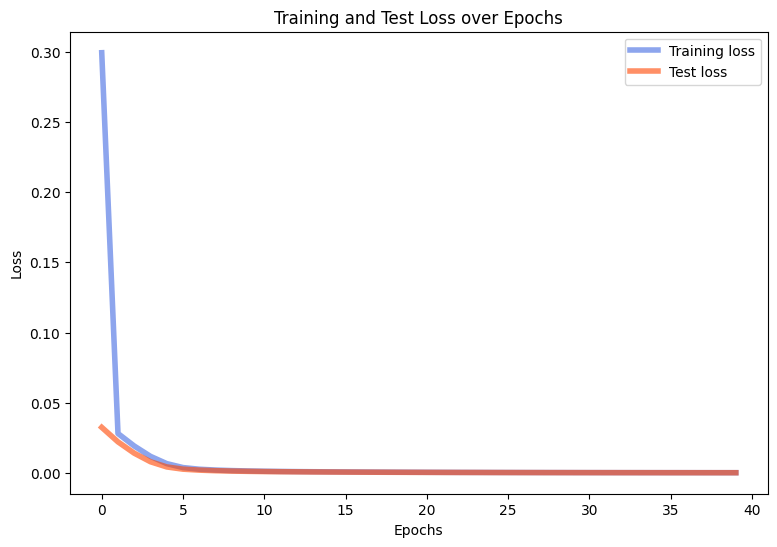

,Epoch,Train Loss,Test Loss
30,31,0.000120,0.000097
31,32,0.000109,0.000088
32,33,0.000099,0.000081
33,34,0.000089,0.000075
34,35,0.000081,0.000067
35,36,0.000074,0.000061
36,37,0.000067,0.000056
37,38,0.000062,0.000052
38,39,0.000057,0.000046
39,40,0.000052,0.000042


In [6]:
# plotting the training and test loss
plt.figure(figsize=(9, 6))
plt.plot(loss_history['train'], label='Training loss', color = 'royalblue', alpha = 0.6, linewidth = 4)
plt.plot(loss_history['test'], label='Test loss', color = 'orangered', alpha = 0.6, linewidth =4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()


# creating loss history dataframe 
loss_df = pd.DataFrame({
    'Epoch': range(1, epochs + 1),
    'Train Loss': loss_history['train'],
    'Test Loss': loss_history['test']
})

#printing the last ten entries. still decreasing, so could maybe run for more epochs
loss_df.tail(10)

Visually, our loss appears to be going down consistently for both training and testing, so we are not seeing signs of overfitting. 

Let's create a new dataset in the same manner, and test the model performance when it comes to prediction. I generated one of size 1000, but this can easily be changed. 

In [7]:
# generating a new dataset for testing
new_x = np.random.uniform(-1, 1, 1000) # only need to change these numbers to change dataset size 
new_y = np.random.uniform(-1, 1, 1000) # currently at 1000 but visuals get cooler with higher numbers  
new_z = np.sqrt(np.square(new_x) + np.square(new_y))

# converting to torch tensors 
new_x_tensor = torch.from_numpy(new_x).float()
new_y_tensor = torch.from_numpy(new_y).float()
new_z_tensor = torch.from_numpy(new_z).float()

# new set of inputs for the model
new_inputs_tensor = torch.column_stack((new_x_tensor, new_y_tensor))

model.eval()  # set model to evaluation mode
with torch.no_grad():
    new_predictions = model(new_inputs_tensor).squeeze() #make new predictions

new_predictions_np = new_predictions.numpy()

# calculating MAD for fun 
mad = np.mean(np.abs(new_predictions_np - new_z))
print("Mean Absolute Deviation on Test Data: ", mad)


Mean Absolute Deviation on Test Data:  0.0038155859942575724


Appears we have a pretty small MAD. Let's plot predicted vs actual values, and add a line for predicted = actual. The closer the values are to the line, the better the model is doing. 

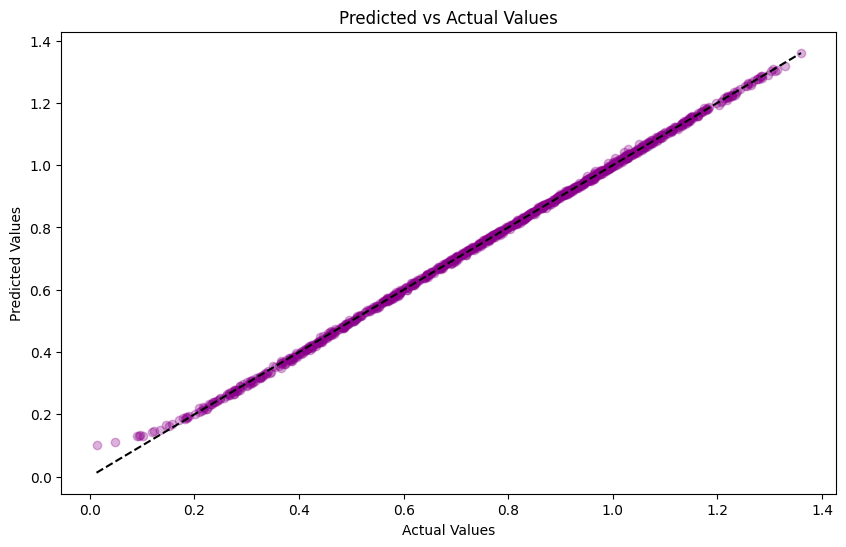

In [8]:
# plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(new_z, new_predictions_np, color = 'darkmagenta', alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([new_z.min(), new_z.max()], [new_z.min(), new_z.max()], 'k--')  # predicted = actual diagonal line
plt.show()

Small values appear to be overpredicted, but aside from that, all looks good. 

Next, let's make a 3d scatter plot of the predicted and actual values so we get a nice picture of the actual surface and the one being learned. 

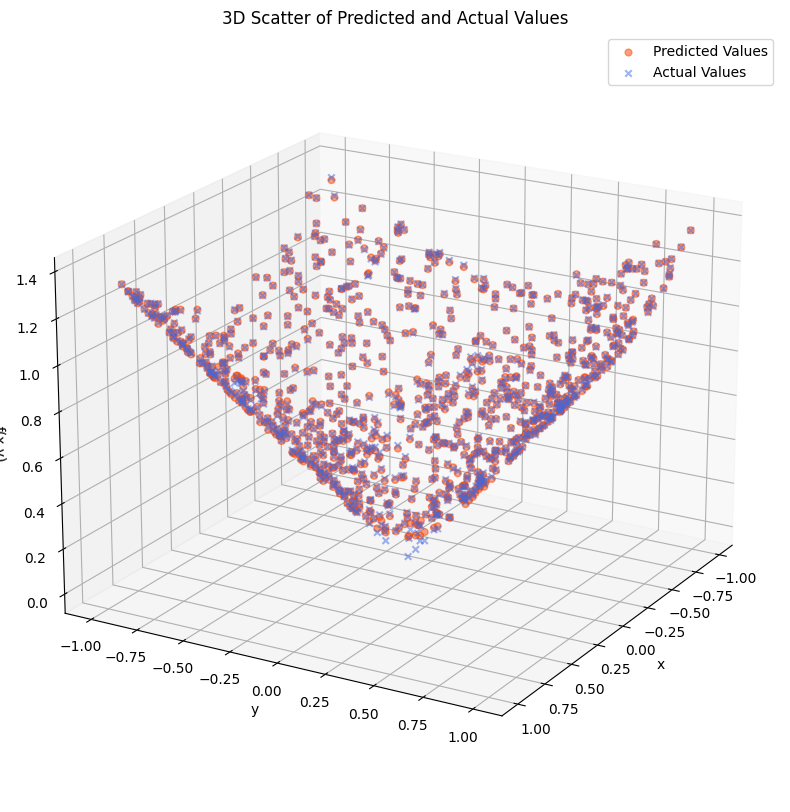

In [9]:
# setup for 3d plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# predicted values
ax.scatter(new_x, new_y, new_predictions_np, 
           color='orangered', label='Predicted Values', 
           alpha = 0.5, s = 24, marker = "o")

# actual values 
ax.scatter(new_x, new_y, new_z, 
           color='royalblue', label='Actual Values', 
           alpha = 0.5, s = 22, marker = "x")

elevation_angle = 20 #can change these angles for different viewing perspectives 
azimuthal_angle = 30  
ax.view_init(elev=elevation_angle, azim=azimuthal_angle)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
ax.set_title('3D Scatter of Predicted and Actual Values')
ax.legend()

plt.show()



The predicted values are the orangered circles, while the actual values (target values) are blue X's. The transparency levels and color can be changed, but we are essentially seeing predictions right on top of targets, which is a good sign. Once again, we can see the net struggle with the really small values, creating some separation between predicted and actual at the very bottom. Overall, a fun exercise. 